In [25]:
# 自动计算cell的计算时间
%load_ext autotime

%matplotlib inline
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 12.2 ms (started: 2021-08-18 23:00:21 +08:00)


In [27]:
%%bash

# 增加更新
git add *.ipynb *.md

git remote -v

git commit -m '更新 ch14 #4  Aug 18, 2021'

git push origin master

origin	git@github.com:ustchope/handson-ml2.git (fetch)
origin	git@github.com:ustchope/handson-ml2.git (push)
[master f9087be] 更新 ch14 #4  Aug 18, 2021
 1 file changed, 1118 insertions(+), 156 deletions(-)


To git@github.com:ustchope/handson-ml2.git
   3b6927f..f9087be  master -> master


time: 6.16 s (started: 2021-08-18 23:16:26 +08:00)


In [26]:
#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 894 µs (started: 2021-08-18 23:00:23 +08:00)


# 使用卷积神经网络的深度计算机视觉

尽管 IBM 的深蓝超级计算机早在 1996 年就击败了国际象棋世界冠军加里·卡斯帕罗夫，但直到最近，计算机才能够可靠地执行看似微不足道的任务，例如检测图片中的小狗或识别口语。 为什么这些任务对我们人类来说如此轻松？ 答案在于，感知主要发生在我们的意识领域之外，在我们大脑中专门的视觉、听觉和其他感官模块内。 当感官信息到达我们的意识时，它已经被高级特征所装饰； 例如，当你看一张可爱的小狗的照片时，你不能选择不看小狗，不注意它的可爱。 你也无法解释你是如何认出一只可爱的小狗的； 这对你来说很明显。 因此，我们不能相信我们的主观经验：感知根本不是微不足道的，要理解它，我们必须看看感官模块是如何工作的。

卷积神经网络 (CNN) 起源于对大脑视觉皮层的研究，自 1980 年代以来一直用于图像识别。 在过去的几年里，由于计算能力的增加、可用训练数据的数量以及第 11 章中介绍的训练深度网络的技巧，CNN 已经在一些复杂的视觉任务上取得了超人的表现。 它们为图像搜索服务、自动驾驶汽车、自动视频分类系统等提供支持。 此外，CNN 不仅限于视觉感知：它们在许多其他任务上也很成功，例如语音识别和自然语言处理。 但是，我们现在将专注于可视化应用程序。

在本章中，我们将探讨 CNN 的来源、它们的构建块是什么样的，以及如何使用 TensorFlow 和 Keras 实现它们。 然后我们将讨论一些最好的 CNN 架构，以及其他视觉任务，包括对象检测（对图像中的多个对象进行分类并在它们周围放置边界框）和语义分割（根据对象的类别对每个像素进行分类） 属于）。

## 视觉皮层的架构

David H. Hubel 和 Torsten Wiesel 在 1958 年和 1959 年（以及几年后在猴子身上）对猫进行了一系列实验，对视觉皮层的结构提供了重要的见解（作者获得了诺贝尔生理学或医学奖） 1981 年为他们的工作）。特别是，他们发现视觉皮层中的许多神经元有一个小的局部感受野，这意味着它们只对位于视野有限区域内的视觉刺激做出反应（见图 14-1，其中 5 个局部感受野）神经元用虚线圆圈表示）。不同神经元的感受野可能重叠，它们一起平铺整个视野。

此外，作者表明，一些神经元仅对水平线的图像作出反应，而其他神经元仅对不同方向的线作出反应（两个神经元可能具有相同的感受野，但对不同的线方向作出反应）。他们还注意到一些神经元具有更大的感受野，它们对更复杂的模式做出反应，这些模式是较低级别模式的组合。这些观察导致了这样的想法：高级神经元基于相邻的低级神经元的输出（在图 14-1 中，请注意每个神经元仅连接到前一层的几个神经元）。这种强大的架构能够检测视野任何区域的各种复杂模式。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtkyd76lsmj61ak0meae602.jpg)

这些对视觉皮层的研究启发了新认知机，1980 年引入，逐渐演变成我们现在所说的卷积神经网络。 一个重要的里程碑是 Yann LeCun 等人 1998 年的一篇论文。 引入了著名的 LeNet-5 架构，被银行广泛用于识别手写支票号码。 这个架构有一些你已经知道的构建块，比如全连接层和 sigmoid 激活函数，但它也引入了两个新的构建块：卷积层和池化层。 现在让我们看看它们。

> 为什么不简单地使用具有全连接层的深度神经网络来执行图像识别任务？ 不幸的是，尽管这对于小图像（例如 MNIST）来说效果很好，但由于需要大量参数，它对于较大的图像会失效。 例如，一张 100 × 100 像素的图像有 10,000 个像素，如果第一层只有 1,000 个神经元（这已经严重限制了传输到下一层的信息量），这意味着总共有 1000 万个连接。 这只是第一层。 CNN 使用部分连接的层和权重共享来解决这个问题。

## 卷积层

CNN 最重要的构建块是卷积层：第一个卷积层中的神经元并没有连接到输入图像中的每个像素（就像它们在前几章讨论的层中一样），而仅连接到它们的接受像素 字段（见图 14-2）。 反过来，第二个卷积层中的每个神经元只连接到位于第一层小矩形内的神经元。 这种架构允许网络在第一个隐藏层专注于小的低级特征，然后在下一个隐藏层将它们组装成更大的更高级特征，依此类推。 这种层次结构在现实世界的图像中很常见，这也是 CNN 在图像识别方面表现如此出色的原因之一。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtkyj3v3fdj619i0m6gnq02.jpg)

> 到目前为止，我们看到的所有多层神经网络都有由一长串神经元组成的层，我们必须将输入图像展平为 1D，然后再将它们输入神经网络。 在 CNN 中，每一层都以 2D 形式表示，这使得将神经元与其相应的输入相匹配变得更容易。

位于给定层第 i 行、第 j 列的神经元连接到位于第 i 行到 i + fh – 1、第 j 列到 j + fw – 1 行的前一层神经元的输出，其中 fh 和 fw 是 感受野的高度和宽度（见图 14 3）。 为了使图层具有与前一层相同的高度和宽度，通常在输入周围添加零，如图所示。 这称为零填充。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtkyllbfdgj618u0q6tc202.jpg)

还可以通过将感受野隔开来将一个大的输入层连接到一个小得多的层，如图 14-4 所示。 这大大降低了模型的计算复杂度。 从一个感受野到下一个感受野的转变称为步幅。 在图中，一个 5 × 7 的输入层（加上零填充）连接到一个 3 × 4 的层，使用 3 × 3 的感受野和 2 的步幅（在这个例子中，两个方向的步幅相同，但它 不必如此）。 位于上层第 i 行、第 j 列的神经元连接到位于第 $i × s_h$ 至 $i × s_h + f_h – 1$、第 $j × s_w$ 至 $j × s_w + f_w$ 列的上一层神经元的输出 – 1，其中 $s_h$ 和 $s_w$ 是垂直和水平步幅。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtkyninpq4j619c0o4ad202.jpg)

### 卷积核

神经元的权重可以表示为感受野大小的小图像。 例如，图 14-5 显示了两组可能的权重，称为过滤器（或卷积核）。 第一个表示为一个黑色方块，中间有一条垂直的白线（它是一个 7 × 7 的矩阵，除了中央一列全是 1 之外，全是 0）； 使用这些权重的神经元将忽略其感受野中除中央垂直线之外的所有内容（因为所有输入都将乘以 0，除了位于中央垂直线上的输入）。 第二个过滤器是一个黑色方块，中间有一条水平白线。 再一次，使用这些权重的神经元将忽略其感受野中除中央水平线之外的所有内容。

现在，如果一层中的所有神经元都使用相同的垂直线滤波器（和相同的偏置项），并且您将图 14-5 所示的输入图像（底部图像）提供给网络，则该层将输出左上角的图像 . 请注意，垂直白线得到增强，而其余部分变得模糊。 类似地，如果所有神经元都使用相同的水平线过滤器，则您会得到右上方的图像； 请注意，水平白线得到增强，而其余部分变得模糊。 因此，一个充满神经元的层使用相同的过滤器输出一个特征图，它突出显示图像中激活过滤器最多的区域。 当然，您不必手动定义过滤器：相反，在训练期间，卷积层将自动学习对其任务最有用的过滤器，并且上面的层将学习将它们组合成更复杂的模式。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtkyqx80hdj618z0u0td502.jpg)

### 堆叠多个特征图

到现在为止，为了简单起见，我已经将每个卷积层的输出表示为一个 2D 层，但实际上一个卷积层有多个过滤器（您决定多少）并且每个过滤器输出一个特征图，因此更准确地表示 在 3D 中（见图 14-6）。 它在每个特征图中每个像素有一个神经元，并且给定特征图中的所有神经元共享相同的参数（即相同的权重和偏置项）。 不同特征图中的神经元使用不同的参数。 神经元的感受野与前面描述的相同，但它扩展到所有先前层的特征图。 简而言之，卷积层同时将多个可训练滤波器应用于其输入，使其能够在其输入的任何位置检测多个特征。

特征图中的所有神经元共享相同的参数这一事实大大减少了模型中的参数数量。 一旦 CNN 学会了在一个位置识别模式，它就可以在任何其他位置识别它。 相比之下，一旦常规 DNN 学会了在一个位置识别模式，它只能在该特定位置识别它。

输入图像也由多个子层组成：每个颜色通道一个。 通常有三种：红色、绿色和蓝色 (RGB)。 灰度图像只有一个通道，但有些图像可能有更多通道——例如，捕获额外光频率（如红外线）的卫星图像。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtkytksmnkj60pw0o6acq02.jpg)

具体来说，位于给定卷积层 l 中特征图 k 的第 i 行第 j 列的神经元连接到前一层 $l – 1$ 中位于第 $i × s_h$ 到 $i × s_h + f_h$ 行的神经元的输出 – 1 列 $j × s_w$ 到 $j × s_w + f_w – 1$，跨越所有特征图（在第 $l – 1$ 层）。 请注意，位于同一行 i 和列 j 但在不同特征图中的所有神经元都连接到前一层中完全相同的神经元的输出。

公式 14-1 在一个大的数学公式中总结了前面的解释：它显示了如何计算卷积层中给定神经元的输出。 由于所有不同的索引，它有点难看，但它所做的只是计算所有输入的加权和，加上偏差项。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtkz42dytpj616408g75802.jpg)

在这个等式中：

* $z_{i, j, k}$ 是位于卷积层（第l 层）的特征图k 中第i 行第j 列的神经元的输出。
* 如前所述，$s_h$ 和$s_w$ 是垂直和水平步长，$f_h$ 和$f_w$ 是感受野的高度和宽度，$f_{n'}$ 是前一层（层$l – 1$）中的特征图的数量。
* $x_{i', j', k'}$ 是位于第 $l – 1$ 层，第 $i'$ 行，第 $j'$ 列，特征图 $k'$（如果前一层是输入层，则为通道 $k'$）中神经元的输出。
* $b_k$ 是特征图k（在第l 层）的偏置项。 您可以将其视为调整特征图 k 整体亮度的旋钮。 
* $w_{u, v, k′ ,k}$ 是第 $l$ 层的特征图 $k$ 中的任何神经元与其位于第 $u$ 行、第 $v$ 列（相对于神经元的感受野）和特征图 $k′$ 的输入之间的连接权重。

### TensorFlow 实现

在 TensorFlow 中，每个输入图像通常表示为形状 [高度、宽度、通道] 的 3D 张量。 小批量表示为形状 [小批量大小、高度、宽度、通道] 的 4D 张量。 卷积层的权重表示为形状为 [$f_h, f_w, f_{n'}, f_n$] 的 4D 张量。 卷积层的偏置项简单地表示为形状为 [$f_n$] 的一维张量。

我们来看一个简单的例子。 下面的代码使用 Scikit-Learn 的 `load_sample_image()` 加载两个示例图像（加载两个彩色图像，一个是中国寺庙，另一个是花），然后创建两个过滤器并将它们应用于两个图像，最后 它显示生成的特征图之一。 请注意，您必须通过 `pip` 安装 `Pillow` 包才能使用 `load_sample_image()`。

In [4]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255

time: 1.16 s (started: 2021-08-18 15:38:29 +08:00)


In [7]:
china.shape

(427, 640, 3)

time: 2.66 ms (started: 2021-08-18 15:39:09 +08:00)


In [10]:
import matplotlib.pyplot as plt
import numpy as np
#plt.imshow(china)

images = np.array([china, flower])

batch_size, height, width, channels = images.shape

time: 13.5 ms (started: 2021-08-18 15:41:16 +08:00)


In [11]:
images.shape

(2, 427, 640, 3)

time: 2.99 ms (started: 2021-08-18 15:41:30 +08:00)


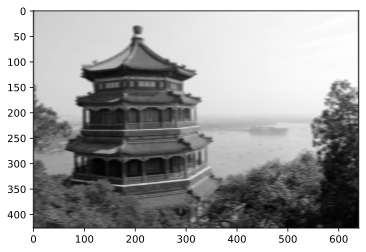

time: 7.47 s (started: 2021-08-18 15:43:03 +08:00)


In [12]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)

filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

让我们来看看这段代码：
* 每个颜色通道的像素强度表示为从 0 到 255 的一个字节，因此我们只需通过除以 255 来缩放这些特征，以获得范围从 0 到 1 的浮点数。
* 然后我们创建两个 7 × 7 过滤器（一个中间有一条垂直的白线，另一个中间有一条水平的白线）。
* 我们使用 tf.nn.conv2d() 函数将它们应用于两个图像，该函数是 TensorFlow 的低级深度学习 API 的一部分。 在这个例子中，我们使用零填充（padding="SAME"）和 1 的步幅。
* 最后，我们绘制生成的特征图之一（类似于图 14-5 中的右上角图像）。

tf.nn.conv2d() 行值得更多解释：
* 图像是输入小批量（4D 张量，如前所述）。
* 过滤器是要应用的一组过滤器（也是 4D 张量，如前所述）。
* strides 等于1，但它也可以是具有四个元素的一维数组，其中两个中心元素是垂直和水平步长（$s_h$ 和$s_w$）。第一个和最后一个元素当前必须等于 1。它们有一天可能用于指定批处理步幅（跳过某些实例）和通道步幅（跳过一些前一层的特征图或通道）。
* padding 
    - 必须是“SAME”或“VALID”：——如果设置为“SAME”，卷积层在必要时使用零填充。输出大小设置为输入神经元的数量除以步幅，四舍五入。例如，如果输入大小为 13，步长为 5（见图 14-7），则输出大小为 3（即 13 / 5 = 2.6，四舍五入为 3）。然后在输入周围尽可能均匀地添加零，根据需要当 strides=1 时，层的输出将具有与其输入相同的空间维度（宽度和高度），因此名称相同。
    - 如果设置为“VALID”，则卷积层不使用零填充，可能会忽略输入图像底部和右侧的一些行和列，具体取决于步幅，如图 14-7 所示（为简单起见，仅 此处显示的是水平维度，但当然相同的逻辑适用于垂直维度）。 这意味着每个神经元的感受野都严格位于输入内部的有效位置（它不会越界），因此名称有效。

在这个例子中，我们手动定义了过滤器，但在真正的 CNN 中，您通常会将过滤器定义为可训练变量，以便神经网络可以了解哪些过滤器效果最好，如前所述。 使用 keras.layers.Conv2D 层，而不是手动创建变量：

In [ ]:
conv = keras.layers.Conv2D(filters=32, 
                           kernel_size=3, 
                           strides=1,
                           padding="same", 
                           activation="relu")

这段代码创建了一个包含 32 个过滤器的 Conv2D 层，每个过滤器为 3 × 3，使用 1 步长（水平和垂直）和“相同”填充，并将 ReLU 激活函数应用于其输出。 如您所见，卷积层有很多超参数：您必须选择过滤器的数量、高度和宽度、步幅和填充类型。 与往常一样，您可以使用交叉验证来找到正确的超参数值，但这非常耗时。 我们稍后将讨论常见的 CNN 架构，让您了解哪些超参数值在实践中效果最佳。

### 内存要求

CNN 的另一个问题是卷积层需要大量 RAM。在训练期间尤其如此，因为反向传播的反向传播需要在正向传播期间计算的所有中间值。

例如，考虑一个具有 5 × 5 滤波器的卷积层，输出 200 个大小为 150 × 100、步幅为 1 和“相同”填充的特征图。如果输入是 150 × 100 RGB 图像（三个通道），则参数数量为 (5 × 5 × 3 + 1) × 200 = 15,200（+1 对应于偏差项），相比之下相当小7 然而，200 个特征图中的每一个都包含 150 × 100 个神经元，每个神经元都需要计算其 5 × 5 × 3 = 75 个输入的加权和：总共 2.25 亿个浮点数乘法。不像全连接层那么糟糕，但仍然是计算密集型的。此外，如果特征图使用 32 位浮点数表示，那么卷积层的输出将占用 200 × 150 × 100 × 32 = 9600 万位（12 MB）的 RAM。这只是一个例子——如果训练批处理包含 100 个实例，那么这一层将使用 1.2 GB 的 RAM！

在推理期间（即对新实例进行预测时），只要计算下一层，就可以释放一层占用的 RAM，因此您只需要两个连续层所需的 RAM。 但是在训练期间，前向传递期间计算的所有内容都需要保留以供反向传递使用，因此所需的 RAM 量（至少）是所有层所需的 RAM 总量。

如果训练因内存不足错误而崩溃，您可以尝试减小小批量大小。 或者，您可以尝试使用步幅降低维度，或删除几层。 或者您可以尝试使用 16 位浮点数而不是 32 位浮点数。 或者您可以将 CNN 分布在多个设备上。

现在让我们看看 CNN 的第二个常见构建块：池化层。

## 池化层

一旦你理解了卷积层的工作原理，池化层就很容易掌握了。 他们的目标是对输入图像进行二次采样（即缩小），以减少计算负载、内存使用和参数数量（从而限制过拟合的风险）。

就像在卷积层中一样，池化层中的每个神经元都连接到前一层中有限数量的神经元的输出，这些神经元位于一个小的矩形感受野内。 您必须像以前一样定义它的大小、步幅和填充类型。 然而，池化神经元没有权重。 它所做的只是使用聚合函数（例如最大值或平均值）聚合输入。 图 14-8 显示了一个最大池化层，它是最常见的池化层类型。 在这个例子中，我们使用一个 2 × 2 的池化内核，步长为 2，没有填充。 只有每个感受野中的最大输入值才能进入下一层，而其他输入则被丢弃。 例如，在图 14-8 左下方的感受野中，输入值为 1、5、3、2，因此只有最大值 5 传播到下一层。 由于步幅为 2，输出图像具有输入图像的一半高度和一半宽度（由于我们不使用填充，因此向下取整）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl033p6evj61ae0j0jv902.jpg)

池化层通常独立地作用于每个输入通道，因此输出深度与输入深度相同。

除了减少计算、内存使用和参数数量之外，最大池化层还为小翻译引入了一定程度的不变性，如图 14-9 所示。这里我们假设亮像素的值低于暗像素，我们考虑三个图像（A、B、C）通过一个最大池化层，内核大小为 2 × 2，步长为 2。图像 B 和 C 是相同的如图像 A，但向右移动了一个和两个像素。如您所见，图像 A 和 B 的最大池化层的输出是相同的。这就是平移不变性的意思。对于图像 C，输出是不同的：它向右移动一个像素（但仍然有 75% 的不变性）。通过在 CNN 中每隔几层插入一个最大池化层，就有可能在更大范围内获得某种程度的平移不变性。此外，最大池化提供了少量的旋转不变性和轻微的尺度不变性。这种不变性（即使它是有限的）在预测不应该依赖于这些细节的情况下很有用，例如在分类任务中。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl05b0i56j615m0oowh502.jpg)

然而，最大池化也有一些缺点。 首先，它显然是非常具有破坏性的：即使使用很小的 2 × 2 内核和 2 步长，输出在两个方向上都会小两倍（因此它的面积会小四倍），只需丢弃 75% 的输入 值。 在某些应用程序中，不变性是不可取的。 以语义分割（根据像素所属的对象对图像中的每个像素进行分类的任务，我们将在本章稍后探讨）：显然，如果输入图像向右平移一个像素，则输出 也应该向右平移一个像素。 这种情况下的目标是等方差，而不是不变性：输入的微小变化应该导致输出的相应微小变化。

### TensorFlow 实现

在 TensorFlow 中实现最大池化层非常简单。 以下代码使用 2 × 2 内核创建最大池化层。 步幅默认为内核大小，因此该层将使用步幅为 2（水平和垂直）。 默认情况下，它使用“有效”填充（即，根本没有填充）：

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

要创建平均池化层，只需使用 AvgPool2D 而不是 MaxPool2D。 正如您所料，它的工作原理与最大池化层完全相同，只是它计算平均值而不是最大值。 平均池化层曾经非常流行，但现在人们大多使用最大池化层，因为它们通常表现更好。 这似乎令人惊讶，因为计算平均值通常比计算最大值丢失的信息少。 但另一方面，最大池化只保留最强的特征，去掉所有无意义的特征，因此下一层得到更清晰的信号。 此外，最大池化提供比平均池化更强的平移不变性，并且它需要的计算量略少。

请注意，最大池化和平均池化可以沿深度维度而不是空间维度执行，尽管这并不常见。 这可以让 CNN 学会对各种特征保持不变。 例如，它可以学习多个过滤器，每个过滤器检测相同模式的不同旋转（例如手写数字；见图 14-10），并且深度最大池化层将确保输出是相同的，无论 回转。 CNN 可以类似地学会对其他任何事物保持不变：厚度、亮度、偏斜、颜色等。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl0a46w3ij612l0u0tbt02.jpg)

Keras 不包含深度最大池化层，但 TensorFlow 的低级深度学习 API 包含：只需使用 tf.nn.max_pool() 函数，并将内核大小和步幅指定为 4 个元组（即大小为 4 的元组） . 每个的前三个值应该是 1：这表示沿着批次、高度和宽度维度的内核大小和步幅应该是 1。最后一个值应该是沿着深度维度你想要的内核大小和步幅——例如 , 3（这必须是输入深度的除数；如果前一层输出 20 个特征图将不起作用，因为 20 不是 3 的倍数）：

In [ ]:
output = tf.nn.max_pool(images,
                        ksize=(1, 1, 1, 3),
                        strides=(1, 1, 1, 3),
                        padding="valid")

如果您想将其作为层包含在 Keras 模型中，请将其包装在 Lambda 层中（或创建自定义 Keras 层）：

In [ ]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), 
                                                          strides=(1, 1, 1, 3),
                                                          padding="valid"))

您在现代架构中经常会看到的最后一种池化层是全局平均池化层。 它的工作方式非常不同：它所做的只是计算每个整个特征图的平均值（它就像一个使用与输入具有相同空间维度的池化内核的平均池化层）。 这意味着它只为每个特征图和每个实例输出一个数字。 虽然这当然是极具破坏性的（特征图中的大部分信息都丢失了），但它可以用作输出层，我们将在本章后面看到。 要创建这样的层，只需使用 keras.layers.GlobalAvgPool2D 类：

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

它相当于这个简单的 Lambda 层，它计算空间维度（高度和宽度）的平均值：

In [ ]:
global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

现在您已经了解了创建卷积神经网络的所有构建块。 让我们看看如何组装它们。

## CNN架构

典型的 CNN 架构堆叠了几个卷积层（每个卷积层后通常跟一个 ReLU 层），然后是一个池化层，然后是另外几个卷积层（+ReLU），然后是另一个池化层，依此类推。 随着图像在网络中前进，图像变得越来越小，但由于卷积层（见图 14-11），它通常也会变得越来越深（即具有更多的特征图）。 在堆栈的顶部，添加了一个常规的前馈神经网络，由几个全连接层（+ReLU）组成，最后一层输出预测（例如，输出估计类概率的 softmax 层）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl0ngl4qxj61e60g0whe02.jpg)

> 一个常见的错误是使用过大的卷积核。 例如，不使用具有 5 × 5 内核的卷积层，而是将具有 3 × 3 内核的两层堆叠起来：它会使用更少的参数和更少的计算，并且通常会表现得更好。 一个例外是第一个卷积层：它通常可以有一个大内核（例如，5 × 5），通常步幅为 2 或更多：这将减少图像的空间维度而不会丢失太多信息，并且由于 输入图像一般只有三个通道，成本不会太高。

以下是如何实现一个简单的 CNN 来处理 Fashion MNIST 数据集（在第 10 章中介绍）：

In [16]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
    input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

time: 162 ms (started: 2021-08-18 16:25:11 +08:00)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

让我们来看看这个模型：
* 第一层使用 64 个相当大的过滤器 (7 × 7) 但没有步幅，因为输入图像不是很大。它还设置 input_shape=[28, 28, 1]，因为图像是 28 × 28 像素，具有单个颜色通道（即灰度）。
* 接下来我们有一个最大池化层，它使用池大小为 2，因此它将每个空间维度除以因子 2。
* 然后我们重复两次相同的结构：两个卷积层，然后是一个最大池化层。对于较大的图像，我们可以多次重复此结构（重复次数是您可以调整的超参数）。
* 请注意，当我们将 CNN 向上爬向输出层时，过滤器的数量会增加（最初是 64，然后是 128，然后是 256）：它的增长是有意义的，因为低级特征的数量通常相当低（例如，小圆圈、水平线），但是有许多不同的方法可以将它们组合成更高级别的特征。将每个池化层后的过滤器数量加倍是一种常见的做法：由于池化层将每个空间维度除以因子 2，因此我们可以将下一层中的特征图数量加倍，而不必担心数量会爆炸参数、内存使用或计算负载。
* 接下来是全连接网络，由两个隐藏密集层和一个密集输出层组成。请注意，我们必须展平其输入，因为密集网络需要每个实例的一维特征数组。我们还添加了两个 dropout 层，每个 dropout 层的 dropout 率为 50%，以减少过拟合。

这个 CNN 在测试集上达到了 92% 以上的准确率。它不是最先进的，但它非常好，显然比我们在第 10 章中使用密集网络实现的要好得多。

多年来，已经开发了这种基本架构的变体，从而在该领域取得了惊人的进步。这种进步的一个很好的衡量标准是诸如 ILSVRC ImageNet 挑战赛等比赛中的错误率。在这场比赛中，图像分类的前五名错误率在短短六年内从超过 26% 下降到不到 2.3%。前五名错误率是系统的前五名预测不包括正确答案的测试图像的数量。图像很大（256 像素高），有 1,000 个类别，其中一些非常微妙（尝试区分 120 个狗品种）。查看获奖作品的演变是了解 CNN 如何工作的好方法。

我们将首先看看经典的 LeNet-5 架构（1998 年），然后是 ILSVRC 挑战赛的三位获胜者：AlexNet（2012 年）、GoogLeNet（2014 年）和 ResNet（2015 年）。

### LeNet-5

LeNet-5 架构 10 可能是最广为人知的 CNN 架构。 如前所述，它由 Yann LeCun 于 1998 年创建，并已广泛用于手写数字识别（MNIST）。 它由表 14-1 所示的层组成。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl0z5jwr4j613k0fqq4d02.jpg)

还有一些额外的细节需要注意：
* MNIST 图像为 28 × 28 像素，但在输入网络之前将它们补零至 32 × 32 像素并进行归一化处理。网络的其余部分不使用任何填充，这就是为什么随着图像在网络中前进，尺寸不断缩小。
* 平均池化层比平常稍微复杂一些：每个神经元计算其输入的平均值，然后将结果乘以一个可学习系数（每个映射一个）并添加一个可学习的偏差项（同样，每个映射一个），然后最后应用激活函数。
* C3 映射中的大多数神经元仅连接到三个或四个 S2 映射（而不是所有六个 S2 映射）中的神经元。有关详细信息，请参阅原始论文 10 中的表 1（第 8 页）。
* 输出层有点特殊：不是计算输入和权重向量的矩阵乘法，而是每个神经元输出其输入向量与其权重向量之间的欧几里得距离的平方。每个输出测量图像属于特定数字类别的程度。现在首选交叉熵成本函数，因为它会更多地惩罚错误的预测，产生更大的梯度并更快地收敛。

Yann LeCun 的网站提供了 LeNet-5 分类数字的精彩演示。

### AlexNet

AlexNet CNN 架构 11 在 2012 年 ImageNet ILSVRC 挑战赛中大获全胜：它实现了 17% 的前五名错误率，而第二名的错误率仅为 26%！ 它由 Alex Krizhevsky（因此得名）、Ilya Sutskever 和 Geoffrey Hinton 开发。 它与 LeNet-5 类似，只是更大更深，并且它是第一个将卷积层直接堆叠在一起，而不是在每个卷积层的顶部堆叠池化层。 表 14-2 展示了这种架构。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl13h8iycj614g0lodif02.jpg)

为了减少过拟合，作者使用了两种正则化技术。 首先，他们在训练期间对 F9 和 F10 层的输出应用了 dropout（在第 11 章中介绍），dropout 率为 50%。 其次，他们通过以各种偏移量随机移动训练图像、水平翻转它们并改变光照条件来执行数据增强。

**数据增强**

---

数据增强通过生成每个训练实例的许多真实变体来人为地增加训练集的大小。这减少了过度拟合，使其成为一种正则化技术。生成的实例应该尽可能真实：理想情况下，给定来自增强训练集的图像，人类不应该能够判断它是否被增强。简单地添加白噪声无济于事；修改应该是可学习的（白噪声不是）。

例如，您可以将训练集中的每张图片略微移动、旋转和调整大小，并将结果图片添加到训练集中（见图 14-12）。这迫使模型更能容忍图片中对象的位置、方向和大小的变化。对于更能容忍不同光照条件的模型，您可以类似地生成许多具有不同对比度的图像。一般情况下，也可以水平翻转图片（文字和其他不对称对象除外）。通过组合这些转换，您可以大大增加训练集的大小。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl1802n0bj61020pg7ay02.jpg)

---

AlexNet 还在 C1 和 C3 层的 ReLU 步骤之后立即使用竞争归一化步骤，称为局部响应归一化 (LRN)：最强烈激活的神经元抑制位于相邻特征图中相同位置的其他神经元（这种竞争性激活已被观察到 在生物神经元中）。 这鼓励不同的特征图进行专业化，将它们分开并迫使它们探索更广泛的特征，最终提高泛化能力。 公式 14-2 显示了如何应用 LRN。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl3sq26r5j613608wgm902.jpg)

在这个等式中：
* $b_i$ 是位于特征图 $i$ 中某行 $u$ 和 $v$ 列的神经元的归一化输出（注意，在此等式中，我们只考虑位于该行和该列的神经元，因此未显示 $u$ 和 $v$）。
* $a_i$ 是在 ReLU 步骤之后但在归一化之前激活该神经元。
* $k, \alpha, \beta $ 和 $r$ 是超参数。 $k$ 称为偏差，$r$ 称为深度半径。
* $f_n$ 是特征图的数量。

例如，如果 r = 2 并且一个神经元具有很强的激活，它将抑制位于其自身上方和下方的特征图中的神经元的激活。

在 AlexNet 中，超参数设置如下：r = 2、α = 0.00002、β = 0.75 和 k = 1。可以使用 tf.nn.local_response_normalization() 函数（您可以将其包装在 Lambda 如果你想在 Keras 模型中使用它）。

AlexNet 的变体 ZF Net12 由 Matthew Zeiler 和 Rob Fergus 开发，并赢得了 2013 年 ILSVRC 挑战赛。 它本质上是带有一些调整过的超参数（特征图的数量、内核大小、步幅等）的 AlexNet。

### GoogLeNet

GoogLeNet 架构由 Christian Szegedy 等人开发。 来自 Google Research，它通过将前五名错误率降低到 7% 以下赢得了 ILSVRC 2014 挑战。 如此出色的性能很大程度上来自于网络比以前的 CNN 更深的事实（如图 14-14 所示）。 这是通过称为初始模块的子网络实现的，它允许 GoogLeNet 比以前的架构更有效地使用参数：GoogLeNet 的参数实际上比 AlexNet 少 10 倍（大约 600 万而不是 6000 万）。

图 14-13 展示了一个 Inception 模块的架构。 符号“3 × 3 + 1(S)”表示该层使用 3 × 3 内核、步长 1 和“相同”填充。 输入信号首先被复制并馈送到四个不同的层。 所有卷积层都使用 ReLU 激活函数。 请注意，第二组卷积层使用不同的内核大小（1 × 1、3 × 3 和 5 × 5），允许它们捕获不同尺度的模式。 另请注意，每一层都使用 1 步长和“相同”填充（甚至是最大池化层），因此它们的输出都具有与输入相同的高度和宽度。 这使得在最终深度连接层中沿深度维度连接所有输出成为可能（即，堆叠来自所有四个顶部卷积层的特征图）。 这个连接层可以在 TensorFlow 中使用 tf.concat() 操作实现，axis=3（轴是深度）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl42k5058j61cs0nmjuv02.jpg)

您可能想知道为什么 Inception 模块具有 1 × 1 内核的卷积层。 这些层肯定不能捕捉任何特征，因为它们一次只看一个像素？ 事实上，这些层有三个目的：
* 虽然它们不能捕捉空间模式，但它们可以捕捉沿深度维度的模式。
* 它们被配置为输出比输入更少的特征图，因此它们充当瓶颈层，这意味着它们降低了维度。 这降低了计算成本和参数数量，加快了训练速度并提高了泛化能力。
* 每对卷积层（[1 × 1, 3 × 3] 和 [1 × 1, 5 × 5]）就像一个强大的卷积层，能够捕捉更复杂的模式。 事实上，这对卷积层不是在图像上扫描一个简单的线性分类器（就像单个卷积层那样），而是在图像上扫描一个两层神经网络。

简而言之，您可以将整个 inception 模块视为类固醇上的卷积层，能够输出捕获各种尺度复杂模式的特征图。

> 每个卷积层的卷积核数是一个超参数。 不幸的是，这意味着您需要为添加的每个初始层调整 6 个超参数

现在让我们看看 GoogLeNet CNN 的架构（见图 14-14）。 每个卷积层和每个池化层输出的特征图数量显示在内核大小之前。 该架构非常深，必须用三列表示，但 GoogLeNet 实际上是一个高堆栈，包括九个初始模块（带有陀螺的盒子）。 inception 模块中的六个数字代表模块中每个卷积层输出的特征图数量（顺序与图 14-13 相同）。 请注意，所有卷积层都使用 ReLU 激活函数。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl47fud6tj60ym0r2jwn02.jpg)

让我们通过这个网络：
* 前两层将图像的高度和宽度除以 4（因此其面积除以 16），以减少计算负载。第一层使用大内核大小，以便保留大部分信息。
* 然后局部响应归一化层确保前面的层学习各种各样的特征（如前所述）。
* 后面有两个卷积层，第一个像瓶颈层。如前所述，您可以将这一对视为单个更智能的卷积层。
* 同样，局部响应归一化层可确保前面的层捕获多种模式。
* 接下来，最大池化层将图像高度和宽度减少 2，再次加快计算速度。
* 然后是九个初始模块的高堆栈，与几个最大池化层交错以降低维度并加速网络。
* 接下来，全局平均池化层输出每个特征图的均值：这会丢弃任何剩余的空间信息，这很好，因为那时没有太多空间信息。实际上，GoogLeNet 输入图像通常预期为 224 × 224 像素，因此在 5 个最大池化层之后，每个层将高度和宽度除以 2，特征图下降到 7 × 7。此外，这是一个分类任务，而不是本地化，所以对象在哪里并不重要。由于这一层带来的降维，在 CNN 的顶部不需要有几个全连接层（就像在 AlexNet 中那样），这大大减少了网络中的参数数量并限制了过拟合的风险。
* 最后一层是不言自明的：用于正则化的 dropout，然后是一个具有 1,000 个单元的全连接层（因为有 1,000 个类）和一个 softmax 激活函数来输出估计的类概率。

该图略有简化：原始的 GoogLeNet 架构还包括插入在第三个和第六个初始模块顶部的两个辅助分类器。 它们都由一个平均池化层、一个卷积层、两个全连接层和一个 softmax 激活层组成。 在训练期间，他们的损失（按比例缩小 70%）被添加到整体损失中。 目标是解决梯度消失问题并规范网络。

然而，后来证明它们的影响相对较小。 谷歌研究人员后来提出了 GoogLeNet 架构的几种变体，包括 Inception-v3 和 Inception-v4，使用稍微不同的 Inception 模块并达到更好的性能。

### VGGNet

ILSVRC 2014 挑战赛的亚军是 VGGNet，它由牛津大学视觉几何组 (VGG) 研究实验室的 Karen Simonyan 和 Andrew Zisserman 开发。 它有一个非常简单和经典的架构，有 2 或 3 个卷积层和一个池化层，然后又是 2 或 3 个卷积层和一个池化层，依此类推（总共只有 16 或 19 个卷积层，具体取决于 VGG 变体），加上具有 2 个隐藏层和输出层的最终密集网络。 它只使用了 3 × 3 个过滤器，但使用了许多过滤器。

### ResNet

何开明等。 使用残差网络（或 ResNet）赢得了 ILSVRC 2015 挑战，其前五名错误率低于 3.6%，令人震惊。 获胜的变体使用了由 152 层组成的极深 CNN（其他变体有 34、50 和 101 层）。 它印证了大趋势：模型越来越深，参数越来越少。 能够训练这样一个深度网络的关键是使用跳过连接（也称为快捷连接）：输入层的信号也被添加到位于堆栈更高一点的层的输出中。 让我们看看为什么这很有用。

训练神经网络时，目标是使其建模目标函数 h(x)。 如果将输入 x 添加到网络的输出（即添加跳过连接），则网络将被迫建模 f(x) = h(x) – x 而不是 h(x)。 这称为残差学习（见图 14-15）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl4fhclb9j61e40mo40b02.jpg)

初始化常规神经网络时，其权重接近于零，因此网络仅输出接近于零的值。 如果添加跳过连接，生成的网络只会输出其输入的副本； 换句话说，它最初对恒等函数进行建模。 如果目标函数非常接近恒等函数（通常是这种情况），这将大大加快训练速度。

此外，如果添加许多跳过连接，即使有几个层尚未开始学习，网络也可以开始取得进展（见图 14-16）。 由于跳过连接，信号可以轻松地穿过整个网络。 深度残差网络可以看作是一堆残差单元（RU），其中每个残差单元都是一个带有跳跃连接的小型神经网络。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl4hp8cx3j60yy0n876c02.jpg)

现在让我们看看 ResNet 的架构（见图 14-17）。 这是令人惊讶的简单。 它的开始和结束与 GoogLeNet 完全一样（除了没有 dropout 层），中间只是一堆非常深的简单残差单元。 每个残差单元由两个卷积层组成（没有池化层！），使用 3 × 3 内核和保留空间维度（步长 1，“相同”填充），使用批量归一化 (BN) 和 ReLU 激活。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl4iwgux8j618a0s0gqu02.jpg)

请注意，特征图的数量每几个残差单元加倍，同时它们的高度和宽度减半（使用步幅为 2 的卷积层）。 发生这种情况时，输入不能直接添加到残差单元的输出中，因为它们的形状不同（例如，这个问题影响了图 14-17 中虚线箭头表示的跳过连接）。 为了解决这个问题，输入通过一个 1 × 1 的卷积层，步长为 2，输出特征图的数量正确（见图 14-18）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl4jsjzjaj61800igtas02.jpg)

ResNet-34 是具有 34 层（仅计算卷积层和全连接层）17 的 ResNet，包含 3 个残差单元，输出 64 个特征图、128 个图的 RU、256 个图的 6 个 RU 和 512 个图的 3 个 RU。 我们将在本章后面实现这个架构。

比这更深的 ResNet，例如 ResNet-152，使用略有不同的残差单元。 它们不是两个具有 256 个特征图的 3 × 3 卷积层，而是使用三个卷积层：首先是一个只有 64 个特征图（少 4 倍）的 1 × 1 卷积层，它充当瓶颈层（如前所述） )，然后是具有 64 个特征图的 3 × 3 层，最后是具有 256 个特征图（4 乘以 64）的另一个 1 × 1 卷积层，用于恢复原始深度。 ResNet-152 包含 3 个这样的 RU，输出 256 个地图，然后是 8 个具有 512 个地图的 RU，高达 36 个具有 1,024 个地图的 RU，最后是 3 个具有 2,048 个地图的 RU。

> Google 的 Inception-v4 架构融合了 GoogLe-Net 和 ResNet 的思想，在 ImageNet 分类上实现了接近 3% 的前五错误率。

### Xception

GoogLeNet 架构的另一个变体值得注意：Xception19（代表 Extreme Inception）由 François Chollet（Keras 的作者）在 2016 年提出，它在一个巨大的视觉任务（3.5 亿张图像和 17,000类）。就像 Inception-v4 一样，它融合了 GoogLeNet 和 ResNet 的思想，但它用一种称为深度可分离卷积层（或简称可分离卷积层）的特殊类型层代替了 inception 模块。这些层以前曾在一些 CNN 架构中使用过，但它们不像 Xception 架构那样处于中心位置。虽然常规卷积层使用过滤器尝试同时捕获空间模式（例如，椭圆形）和跨通道模式（例如，嘴 + 鼻子 + 眼睛 = 脸），但可分离的卷积层强烈假设空间模式和交叉- 通道模式可以单独建模（见图 14-19）。因此，它由两部分组成：第一部分为每个输入特征图应用单个空间过滤器，然后第二部分专门用于跨通道模式——它只是一个具有 1 × 1 过滤器的常规卷积层。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl4o5ylgej618i0tetcw02.jpg)

由于可分离卷积层的每个输入通道只有一个空间过滤器，因此您应该避免在通道太少的层之后使用它们，例如输入层（当然，这就是图 14-19 所表示的，但这只是为了说明目的） . 出于这个原因，Xception 架构从 2 个常规卷积层开始，但架构的其余部分仅使用可分离卷积（总共 34 个），加上一些最大池化层和通常的最终层（一个全局平均池化层和一个 密集输出层）。

您可能想知道为什么 Xception 被认为是 GoogLeNet 的一个变体，因为它根本不包含 Inception 模块。 好吧，正如我们之前所讨论的，初始模块包含带有 1 × 1 过滤器的卷积层：这些过滤器专门用于跨通道模式。 然而，位于它们之上的卷积层是常规卷积层，它们寻找空间和跨通道模式。 因此，您可以将初始模块视为常规卷积层（联合考虑空间模式和跨通道模式）和可分离卷积层（分别考虑它们）之间的中间体。 在实践中，似乎可分离的卷积层通常表现更好。

> 可分离的卷积层比普通卷积层使用更少的参数、更少的内存和更少的计算，并且通常它们甚至表现得更好，所以你应该考虑默认使用它们（除了很少通道的层之后）。

ILSVRC 2016 挑战赛由香港中文大学的 CUImage 团队赢得。 他们使用了许多不同技术的集合，包括称为 GBD-Net 的复杂对象检测系统，以实现低于 3% 的前五名错误率。 尽管这个结果无疑令人印象深刻，但解决方案的复杂性与 ResNets 的简单性形成了对比。 此外，一年后，另一个相当简单的架构表现得更好，正如我们现在将看到的。

### SENet

ILSVRC 2017 挑战赛的获胜架构是 Squeeze-and Excitation Network (SENet)。 这种架构扩展了现有架构，例如初始网络和 ResNets，并提高了它们的性能。 这让 SENet 以惊人的 2.25% 前五错误率赢得了比赛！ Inception 网络和 ResNet 的扩展版本分别称为 SE-Inception 和 SE-ResNet。 提升来自这样一个事实，即 SENet 向原始架构中的每个单元（即每个初始模块或每个残差单元）添加了一个称为 SE 块的小型神经网络，如图 14-20 所示。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl4wapa02j61800kitae02.jpg)

SE 块分析它所连接的单元的输出，只关注深度维度（它不寻找任何空间模式），并了解哪些特征通常最活跃。 然后使用此信息重新校准特征图，如图 14-21 所示。 例如，SE 块可以了解到嘴巴、鼻子和眼睛通常在图片中一起出现：如果您看到嘴巴和鼻子，您应该也看到眼睛。 所以如果块在嘴巴和鼻子特征图中看到强烈的激活，但在眼睛特征图中只有轻微激活，它会提升眼睛特征图（更准确地说，它会减少不相关的特征图）。 如果眼睛与其他东西有些混淆，则此特征图重新校准将有助于解决歧义。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl4z5uk1jj618i0isgnw02.jpg)

SE 块仅由三层组成：全局平均池化层、使用 ReLU 激活函数的隐藏密集层和使用 sigmoid 激活函数的密集输出层（见图 14-22）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl50z95m1j617m0iyabi02.jpg)

如前所述，全局平均池化层计算每个特征图的平均激活：例如，如果它的输入包含 256 个特征图，它将输出 256 个数字，代表每个过滤器的整体响应水平。下一层是“挤压”发生的地方：这一层的神经元明显少于 256 个——通常比特征图的数量（例如，16 个神经元）少 16 倍，因此 256 个数字被压缩成一个小向量（例如，16方面）。这是特征响应分布的低维向量表示（即嵌入）。这个瓶颈步骤迫使 SE 块学习特征组合的一般表示（当我们在第 17 章讨论自动编码器时，我们将再次看到这个原理的作用）。最后，输出层采用嵌入并输出一个重新校准向量，每个特征图包含一个数字（例如，256），每个数字在 0 和 1 之间。然后将特征图乘以这个重新校准向量，因此不相关的特征（低重新校准分数）被缩小，而相关特征（重新校准分数接近 1）被保留。

## 使用 Keras 实现 ResNet-34 CNN

到目前为止描述的大多数 CNN 架构都相当容易实现（尽管通常你会加载一个预训练的网络，正如我们将看到的）。 为了说明这个过程，让我们使用 Keras 从头开始实现一个 ResNet-34。 首先，让我们创建一个 ResidualUnit 层：

In [4]:
from tensorflow import keras
from tensorflow.keras.utils import plot_model

time: 842 µs (started: 2021-08-18 21:16:10 +08:00)


In [5]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, 
                                strides=strides,
                                padding="same", 
                                use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, 
                                strides=1, 
                                padding="same", 
                                use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [keras.layers.Conv2D(filters, 1, 
                                                    strides=strides,
                                                    padding="same", 
                                                    use_bias=False),
                                keras.layers.BatchNormalization()]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers: 
            Z = layer(Z)
        skip_Z = inputs
        
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

time: 1.88 ms (started: 2021-08-18 21:16:14 +08:00)


如您所见，此代码与图 14-18 非常匹配。 在构造函数中，我们创建了所有需要的层：主层是图右侧的层，而跳过层是左侧的层（仅当步幅大于 1 时才需要）。 然后在 call() 方法中，我们让输入通过主层和跳过层（如果有），然后我们添加两个输出并应用激活函数。

接下来，我们可以使用 Sequential 模型构建 ResNet-34，因为它实际上只是一个很长的层序列（现在我们有了 ResidualUnit 类，我们可以将每个残差单元视为单个层）：

In [6]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
    
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

time: 8.34 s (started: 2021-08-18 21:18:15 +08:00)


这段代码中唯一稍微有点棘手的部分是将 ResidualUnit 层添加到模型的循环：如前所述，前 3 个 RU 有 64 个过滤器，然后接下来的 4 个 RU 有 128 个过滤器，依此类推。 然后，当过滤器的数量与前一个 RU 中的相同时，我们将步幅设置为 1，否则我们将其设置为 2。然后我们添加 ResidualUnit，最后我们更新 prev_filters。

令人惊讶的是，在不到 40 行代码中，我们就可以构建赢得 ILSVRC 2015 挑战的模型！ 这展示了 ResNet 模型的优雅和 Keras API 的表现力。 实现其他 CNN 架构并不难。 然而，Keras 内置了几个这样的架构，那么为什么不改用它们呢？

## 使用来自 Keras 的预训练模型

通常，您不必手动实现 GoogLeNet 或 ResNet 等标准模型，因为预训练网络可以通过 keras.applications 包中的一行代码轻松获得。 例如，您可以使用以下代码行加载在 ImageNet 上预训练的 ResNet-50 模型：

In [7]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

time: 5.29 s (started: 2021-08-18 21:20:22 +08:00)


就这样！ 这将创建一个 ResNet-50 模型并下载在 ImageNet 数据集上预训练的权重。 要使用它，您首先需要确保图像具有正确的大小。ResNet-50 模型需要 224 × 224 像素的图像（其他模型可能需要其他尺寸，例如 299 × 299），所以让我们使用 TensorFlow 的 tf.image.resize() 函数来调整我们之前加载的图像的大小：

In [ ]:
images_resized = tf.image.resize(images, [224, 224])

tf.image.resize() 不会保留纵横比。 如果这是一个问题，请在调整大小之前尝试将图像裁剪为适当的纵横比。 两种操作都可以使用 tf.image.crop_and_resize() 一次性完成。

预训练模型假设图像以特定方式进行了预处理。 在某些情况下，他们可能希望输入从 0 缩放到 1，或从 –1 缩放到 1，依此类推。 每个模型都提供了一个 preprocess_input() 函数，您可以使用它来预处理您的图像。 这些函数假设像素值的范围为 0 到 255，因此我们必须将它们乘以 255（因为之前我们将它们缩放到 0-1 范围）：

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

现在我们可以使用预训练模型进行预测：

In [ ]:
Y_proba = model.predict(inputs)

像往常一样，输出 Y_proba 是一个矩阵，每个图像一行，每个类别一列（在这种情况下，有 1,000 个类别）。 如果要显示前 K 个预测，包括类名和每个预测类的估计概率，请使用 decode_predictions() 函数。 对于每张图像，它返回一个包含前 K 个预测的数组，其中每个预测表示为一个包含类标识符、23 其名称和相应置信度分数的数组：

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
        print()

输出如下所示：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtl9mt0zpoj61aa076dgc02.jpg)

正确的类（修道院和雏菊）出现在两个图像的前三个结果中。 考虑到模型必须从 1,000 个类中进行选择，这很好。

如您所见，使用预训练模型创建一个非常好的图像分类器非常容易。 keras.applications 中提供了其他视觉模型，包括几个 ResNet 变体、GoogLeNet 变体（如 Inception-v3 和 Xception）、VGGNet 变体以及 MobileNet 和 MobileNetV2（用于移动应用程序的轻量级模型）。

但是，如果您想对不属于 ImageNet 的图像类别使用图像分类器怎么办？ 在这种情况下，您仍然可以从预训练模型中受益以执行迁移学习。

## 用于迁移学习的预训练模型

如果你想建立一个图像分类器但你没有足够的训练数据，那么重用一个预训练模型的较低层通常是个好主意，正如我们在第 11 章中讨论的那样。 例如，让我们训练一个模型来分类 鲜花图片，重用预训练的 Xception 模型。 首先，让我们使用 TensorFlow Datasets 加载数据集（参见第 13 章）：

In [9]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes # 5

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tf_flowers-train.tfrecord...:   0%|          | 0/3670 [00:00<?, ? examples/s]

Dataset tf_flowers downloaded and prepared to /home/huangwei/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
time: 5min 37s (started: 2021-08-18 21:36:34 +08:00)


请注意，您可以通过设置 with_info=True 来获取有关数据集的信息。 在这里，我们获得了数据集大小和类的名称。 不幸的是，只有一个“训练”数据集，没有测试集或验证集，所以我们需要拆分训练集。 TF Datasets 项目为此提供了一个 API。 例如，让我们将数据集的前 10% 用于测试，接下来的 15% 用于验证，剩余的 75% 用于训练：

In [ ]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit=[10, 15, 75]

test_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set = tfds.load("tf_flowers", split=train_split, as_supervised=True)

接下来我们必须预处理图像。 CNN 需要 224 × 224 的图像，因此我们需要调整它们的大小。 我们还需要通过 Xception 的 preprocess_input() 函数运行图像：

In [16]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

time: 828 µs (started: 2021-08-18 22:05:20 +08:00)


让我们将此预处理函数应用于所有三个数据集，对训练集进行混洗，并为所有数据集添加批处理和预取：

In [ ]:
batch_size = 32

train_set = train_set.shuffle(1000)

train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

如果要执行一些数据增强，请更改训练集的预处理函数，向训练图像添加一些随机变换。 例如，使用 tf.image.random_crop() 随机裁剪图像，使用 tf.image.random_flip_left_right() 随机水平翻转图像，等等（请参阅笔记本的“迁移学习的预训练模型”部分以了解 一个例子）。

> keras.preprocessing.image.ImageDataGenerator 类可以轻松地从磁盘加载图像并以各种方式扩充它们：您可以移动每个图像、旋转它、重新缩放它、水平或垂直翻转它、剪切它或应用任何转换函数 你想要它。 这对于简单的项目来说非常方便。 然而，构建 tf.data 管道有许多优点：它可以从任何来源高效（例如并行）读取图像，而不仅仅是本地磁盘； 您可以随意操作数据集； 如果你编写了一个基于 tf.image 操作的预处理函数，这个函数可以在 tf.data 管道和你将部署到生产的模型中使用（参见第 19 章）。

接下来让我们加载在 ImageNet 上预训练的 Xception 模型。 我们通过设置 include_top=False 排除网络的顶部：这排除了全局平均池化层和密集输出层。 然后我们根据基础模型的输出添加我们自己的全局平均池化层，然后是一个密集输出层，每个类一个单元，使用 softmax 激活函数。 最后，我们创建 Keras 模型：

In [15]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

time: 5.31 s (started: 2021-08-18 22:05:07 +08:00)


如第 11 章所述，冻结预训练层的权重通常是个好主意，至少在训练开始时：

In [18]:
for layer in base_model.layers:
    layer.trainable = False

time: 4.86 ms (started: 2021-08-18 22:11:08 +08:00)


> 由于我们的模型直接使用基础模型的层，而不是 base_model 对象本身，因此设置 base_model.trainable=False 将不起作用。

最后，我们可以编译模型并开始训练：

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

这将非常缓慢，除非您有 GPU。 如果你不这样做，那么你应该在 Colab 中运行本章的笔记本，使用 GPU 运行时（它是免费的！）。 请参阅 https://github.com/ageron/handson-ml2 上的说明。

在对模型进行几个 epoch 训练后，其验证准确率应达到 75-80% 左右，并且不再取得太大进展。 这意味着顶层现在已经训练得很好，所以我们准备解冻所有层（或者你可以尝试只解冻顶层）并继续训练（不要忘记在你冻结或解冻层时编译模型 ）。 这次我们使用低得多的学习率来避免损坏预训练的权重：

In [ ]:
for layer in base_model.layers:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(...)
history = model.fit(...)

这需要一段时间，但这个模型在测试集上应该达到 95% 左右的准确率。 有了它，你就可以开始训练惊人的图像分类器了！ 但计算机视觉不仅仅是分类。 例如，如果您还想知道花在图片中的位置怎么办？ 现在让我们看看这个。

## 分类和定位

定位图片中的对象可以表示为回归任务，如第 10 章所述：要预测对象周围的边界框，常用的方法是预测对象中心的水平和垂直坐标，以及其高度 和宽度。 这意味着我们有四个数字要预测。 它不需要对模型进行太多更改； 我们只需要添加具有四个单元的第二个密集输出层（通常在全局平均池化层的顶部），并且可以使用 MSE 损失进行训练：

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input,
                    outputs=[class_output, 
                             loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

但是现在我们遇到了一个问题：鲜花数据集没有围绕鲜花的边界框。所以，我们需要自己添加它们。这通常是机器学习项目中最困难和最昂贵的部分之一：获取标签。花时间寻找合适的工具是个好主意。要使用边界框注释图像，您可能需要使用开源图像标记工具，例如 VGG Image Annotator、LabelImg、OpenLabeler 或 ImgLab，或者可能是商业工具，例如 LabelBox 或 Supervisely。如果您有大量要注释的图像，您可能还需要考虑众包平台，例如 Amazon Mechanical Turk。但是，搭建众包平台，准备表格发给工人，监督他们，确保他们生产的边界框的质量是好的，所以要确保它是值得的。努力。如果要标记的图像只有几千张，并且您不打算经常这样做，那么最好自己做。阿德里亚娜·科瓦什卡等人。写了一篇关于计算机视觉众包的非常实用的论文。我建议你检查一下，即使你不打算使用众包。

假设您已经获得了花数据集中每个图像的边界框（现在我们假设每个图像有一个边界框）。 然后，您需要创建一个数据集，其项目将是一批经过预处理的图像及其类标签和边界框。 每个项目都应该是形式（图像，（class_labels，bounding_boxes））的元组。 然后你就可以训练你的模型了！

边界框应该标准化，以便水平和垂直坐标以及高度和宽度都在 0 到 1 的范围内。此外，通常预测高度和宽度的平方根而不是高度和宽度 直接：这样，大边界框的 10 像素错误不会像小边界框的 10 像素错误那样受到惩罚。

MSE 通常可以很好地作为训练模型的成本函数，但它不是评估模型预测边界框的好坏指标。 最常见的度量是联合交集 (IoU)：预测边界框和目标边界框之间的重叠区域除以它们的联合区域（见图 14-23）。 在 tf.keras 中，它由 tf.keras.metrics.MeanIoU 类实现。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtlb2osm3rj61eg0sqtgm02.jpg)

对单个对象进行分类和定位很不错，但是如果图像包含多个对象怎么办（就像在花数据集中经常发生的情况一样）？

## 物体检测

对图像中的多个对象进行分类和定位的任务称为对象检测。直到几年前，一种常见的方法是采用经过训练的 CNN 对单个对象进行分类和定位，然后将其滑过图像，如图 14-24 所示。在这个例子中，图像被切割成一个 6 × 8 的网格，我们展示了一个 CNN（黑色粗矩形）在所有 3 × 3 区域上滑动。当 CNN 查看图像的左上角时，它检测到最左侧玫瑰的一部分，然后当它第一次向右移动一步时再次检测到同一朵玫瑰。下一步，它开始检测最上面的玫瑰的一部分，然后再向右移动一步，它再次检测到它。然后，您将继续在整个图像中滑动 CNN，查看所有 3 × 3 区域。此外，由于对象可以有不同的大小，您还可以在不同大小的区域之间滑动 CNN。例如，一旦您完成了 3 × 3 区域，您可能还想在所有 4 × 4 区域上滑动 CNN。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtlb5d5pdjj61du0s6tg402.jpg)

这种技术相当简单，但正如您所见，它会在略有不同的位置多次检测同一个对象。然后将需要一些后处理来摆脱所有不必要的边界框。一种常见的方法称为非最大抑制。以下是您的操作方法：
1. 首先，您需要向 CNN 添加额外的对象性输出，以估计图像中确实存在花的概率（或者，您可以添加“无花”类，但这通常不起作用好）。它必须使用 sigmoid 激活函数，您可以使用二元交叉熵损失来训练它。然后去掉所有对象性分数低于某个阈值的边界框：这将删除所有实际上不包含花的边界框。
2. 找到objectness score最高的bounding box，去掉所有与其重叠的bounding box（例如IoU大于60%）。例如，在图 14-24 中，具有最大对象性分数的边界框是最顶部玫瑰上的厚边界框（对象性分数由边界框的厚度表示）。同一朵玫瑰上的另一个边界框与最大边界框重叠很多，因此我们将去掉它。
3. 重复第二步，直到没有更多的边界框要摆脱。

这种简单的物体检测方法效果很好，但它需要多次运行 CNN，所以速度很慢。 幸运的是，有一种更快的方法可以在图像上滑动 CNN：使用完全卷积网络 (FCN)。

### 全卷积网络

FCN 的想法在 2015 年由 Jonathan Long 等人发表的一篇论文中首次引入，用于语义分割（根据图像所属的对象类别对图像中的每个像素进行分类的任务）。作者指出，您可以用卷积层替换 CNN 顶部的密集层。为了理解这一点，让我们看一个例子：假设一个具有 200 个神经元的密集层位于输出 100 个特征图的卷积层之上，每个特征图的大小为 7 × 7（这是特征图的大小，而不是内核大小）。每个神经元将计算来自卷积层的所有 100 × 7 × 7 激活的加权和（加上偏置项）。现在让我们看看如果我们使用 200 个过滤器（每个过滤器的大小为 7 × 7）和“有效”填充将密集层替换为卷积层会发生什么。该层将输出 200 个特征图，每个 1 × 1（因为内核恰好是输入特征图的大小，并且我们使用了“有效”填充）。换句话说，它会输出 200 个数字，就像密集层一样；如果您仔细观察卷积层执行的计算，您会注意到这些数字与密集层产生的数字完全相同。唯一的区别是密集层的输出是形状为 [batch size, 200] 的张量，而卷积层将输出形状为 [batch size, 1, 1, 200] 的张量。

> 要将密集层转换为卷积层，卷积层中的过滤器数量必须等于密集层中的单元数，过滤器大小必须等于输入特征图的大小，并且必须使用 “valid”填充。 步幅可以设置为 1 或更多，我们很快就会看到。

为什么这很重要？ 好吧，虽然密集层需要特定的输入大小（因为它每个输入特征有一个权重），但卷积层会很乐意处理任何大小的图像（但是，它确实希望其输入具有特定数量的通道，

为什么这很重要？ 好吧，虽然密集层需要特定的输入大小（因为它每个输入特征有一个权重），但卷积层会很乐意处理任何大小的图像（但是，它确实希望其输入具有特定数量的通道，因为每个 内核为每个输入通道包含一组不同的权重）。 由于 FCN 仅包含卷积层（和池化层，它们具有相同的属性），因此可以在任何大小的图像上进行训练和执行！

例如，假设我们已经训练了一个用于花卉分类和定位的 CNN。 它在 224 × 224 图像上训练，并输出 10 个数字：输出 0 到 4 通过 softmax 激活函数发送，这给出了类概率（每个类一个）； 输出 5 通过逻辑激活函数发送，这给出了对象性分数； 输出 6 到 9 不使用任何激活函数，它们表示边界框的中心坐标，以及它的高度和宽度。 我们现在可以将其密集层转换为卷积层。 事实上，我们甚至不需要重新训练它； 我们可以将权重从密集层复制到卷积层！ 或者，我们可以在训练之前将 CNN 转换为 FCN。

现在假设输出层（也称为瓶颈层）之前的最后一个卷积层在网络输入 224 × 224 图像时输出 7 × 7 特征图（见图 14-25 左侧）。如果我们向 FCN 提供 448 × 448 图像（参见图 14 25 的右侧），瓶颈层现在将输出 14 × 14 特征图。 27 由于密集输出层被使用 10 个大小过滤器的卷积层取代7 × 7，具有“有效”填充和步长 1，输出将由 10 个特征图组成，每个特征图的大小为 8 × 8（因为 14 – 7 + 1 = 8）。换句话说，FCN 将只处理整个图像一次，它会输出一个 8 × 8 的网格，其中每个单元格包含 10 个数字（5 个类别概率、1 个对象得分和 4 个边界框坐标）。这就像使用原始 CNN 并使用每行 8 步和每列 8 步在图像上滑动一样。为了可视化这一点，想象一下将原始图像切成 14 × 14 的网格，然后在这个网格上滑动一个 7 × 7 的窗口；窗口将有 8 × 8 = 64 个可能的位置，因此有 8 × 8 个预测。然而，FCN 方法效率更高，因为网络只查看图像一次。事实上，You Only Look Once (YOLO) 是一种非常流行的对象检测架构的名称，我们将在接下来介绍。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtlbiksd76j610s0tgjv102.jpg)

### 你只看一次（YOLO）

YOLO 是 Joseph Redmon 等人提出的一种极其快速和准确的物体检测架构。 在 2015 年的一篇论文中，随后在 2016 年 (YOLOv2) 和 2018 年 (YOLOv3) 中进行了改进。 正如 Redmon 的演示中所见，它非常快，可以在视频上实时运行。

YOLOv3 的架构与我们刚刚讨论的架构非常相似，但有一些重要的区别：
* 它为每个网格单元输出五个边界框（而不是一个），并且每个边界框都带有一个对象性分数。 它还为每个网格单元输出 20 个类别概率，因为它是在包含 20 个类别的 PASCAL VOC 数据集上训练的。 每个网格单元总共有 45 个数字：5 个边界框，每个边界框有 4 个坐标，加上 5 个对象分数，加上 20 个类别概率。
* YOLOv3 不是预测边界框中心的绝对坐标，而是预测相对于网格单元坐标的偏移量，其中 (0, 0) 表示该单元格的左上角，(1, 1) 表示右下角。 对于每个网格单元，YOLOv3 被训练为仅预测中心位于该单元的边界框（但边界框本身通常远远超出网格单元）。 YOLOv3 将逻辑激活函数应用于边界框坐标以确保它们保持在 0 到 1 的范围内。
* 在训练神经网络之前，YOLOv3 找到五个有代表性的边界框维度，称为锚框（或边界框先验）。它通过将 K-Means 算法（参见第 9 章）应用于训练集边界框的高度和宽度来实现这一点。例如，如果训练图像包含许多行人，那么其中一个锚框可能具有典型行人的尺寸。然后当神经网络预测每个网格单元有五个边界框时，它实际上预测了每个锚框的重新缩放比例。例如，假设一个锚框高 100 像素，宽 50 像素，并且网络预测，例如，垂直缩放因子为 1.5，水平缩放因子为 0.9（对于网格单元之一）。这将产生大小为 150 × 45 像素的预测边界框。更准确地说，对于每个网格单元和每个锚框，网络预测垂直和水平缩放因子的对数。拥有这些先验使网络更有可能预测适当维度的边界框，并且它还可以加快训练速度，因为它将更快地了解合理的边界框是什么样子。
* 网络使用不同尺度的图像进行训练：在训练过程中每隔几批，网络随机选择一个新的图像维度（从 330 × 330 到 608 × 608 像素）。这允许网络学习检测不同尺度的对象。此外，它还可以在不同尺度上使用 YOLOv3：较小尺度的准确度较低，但比较大尺度更快，因此您可以为您的用例选择正确的权衡。

还有一些您可能感兴趣的创新，例如使用跳过连接来恢复在 CNN 中丢失的一些空间分辨率（当我们查看语义分割时，我们将很快讨论这个问题）。 在 2016 年的论文中，作者介绍了使用层次分类的 YOLO9000 模型：该模型预测一个称为 WordTree 的视觉层次结构中每个节点的概率。 这使得网络可以高可信度地预测图像代表一只狗，即使它不确定是什么特定类型的狗。 我鼓励您继续阅读所有三篇论文：它们读起来非常愉快，并且它们提供了如何逐步改进深度学习系统的极好例子。

**平均平均精度 (mAP)**

---

对象检测任务中使用的一个非常常见的指标是平均平均精度 (mAP)。 “平均平均值”听起来有点多余，不是吗？ 为了理解这个指标，让我们回到我们在第 3 章中讨论的两个分类指标：准确率和召回率。 记住权衡：召回率越高，精度越低。 您可以在精度/召回曲线中对此进行可视化（参见图 3-5）。 要将这条曲线总结为一个数字，我们可以计算其曲线下面积 (AUC)。 但请注意，精确率/召回率曲线可能包含一些部分，当召回率增加时，精确率实际上会上升，尤其是在召回率较低的情况下（您可以在图 3-5 的左上角看到这一点）。 这是 mAP 指标的动机之一。

假设分类器在 10% 的召回率下有 90% 的准确率，但在 20% 的召回率下有 96% 的准确率。 这里真的没有权衡：在 20% 的召回率而不是 10% 的召回率下使用分类器更有意义，因为您将获得更高的召回率和更高的精度。 因此，我们不应着眼于 10% 召回率时的精度，而应该着眼于分类器在至少 10% 召回率下可以提供的最大精度。 它将是 96%，而不是 90%。 因此，获得模型性能的一个公平概念的一种方法是计算您可以获得的最大精度，至少为 0%，然后是 10%，20%，依此类推，直到 100%，然后计算平均值 这些最大精度。 这称为平均精度 (AP) 指标。 现在当有两个以上的类时，我们可以计算每个类的 AP，然后计算平均 AP（mAP）。 仅此而已！

在物体检测系统中，还有一个额外的复杂度：如果系统检测到正确的类别，但在错误的位置（即边界框完全关闭）怎么办？ 当然，我们不应将此视为积极的预测。 一种方法是定义一个 IOU 阈值：例如，我们可以认为只有当 IOU 大于 0.5 并且预测的类别是正确的时，预测才是正确的。 相应的 mAP 通常记为 mAP@0.5（或 mAP@50%，有时只是 AP50）。 在一些比赛中（例如 PASCAL VOC 挑战赛），就是这样做的。 在其他比赛中（例如 COCO 比赛），mAP 是针对不同的 IOU 阈值（0.50、0.55、0.60、……、0.95）计算的，最终指标是所有这些 mAP 的平均值（注意 AP@[.50:. 95] 或 AP@[.50:0.05:.95]）。 是的，这是一个平均平均值。

---

GitHub 上提供了几个使用 TensorFlow 构建的 YOLO 实现。 特别是，查看 Zihao Zang 的 TensorFlow 2 实现。 TensorFlow 模型项目中提供了其他对象检测模型，其中许多具有预训练权重； 有的甚至已经移植到了TF Hub，比如SSD31和Faster RCNN，这两款都非常流行。 SSD也是一种“单发”检测模型，类似于YOLO。 Faster R-CNN 更复杂：图像首先通过 CNN，然后将输出传递给区域建议网络 (RPN)，该网络提出最有可能包含对象的边界框，并为每个边界运行一个分类器 框，基于 CNN 的裁剪输出。

检测系统的选择取决于许多因素：速度、准确性、可用的预训练模型、训练时间、复杂性等。论文包含指标表，但测试环境存在很大的可变性，技术也在不断发展，因此 很快，很难做出一个对大多数人有用且有效期超过几个月的公平比较。

因此，我们可以通过在对象周围绘制边界框来定位对象。 很好！ 但也许你想要更精确一点。 让我们看看如何下降到像素级别。

## 语义分割

在语义分割中，每个像素根据其所属对象的类别（例如，道路、汽车、行人、建筑物等）进行分类，如图 14-26 所示。注意同一类的不同对象是不区分的。例如，分割图像右侧的所有自行车最终都是一大块像素。该任务的主要难点在于，当图像通过常规 CNN 时，它们逐渐失去其空间分辨率（由于步长大于 1 的层）；所以，一个普通的 CNN 最终可能会知道图像左下角的某个地方有一个人，但它不会比这更精确。

就像对象检测一样，有许多不同的方法可以解决这个问题，有些方法非常复杂。然而，Jonathan Long 等人在 2015 年的论文中提出了一个相当简单的解决方案。我们之前讨论过。作者首先采用预训练的 CNN 并将其转换为 FCN。 CNN 将 32 的总步长应用于输入图像（即，如果将所有步长加起来大于 1），这意味着最后一层输出的特征图比输入图像小 32 倍。这显然太粗糙了，所以他们添加了一个上采样层，将分辨率乘以 32。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtlccbbdeej619c0l2n2002.jpg)

有几种可用于上采样（增加图像大小）的解决方案，例如双线性插值，但仅适用于 ×4 或 ×8。 相反，他们使用转置卷积层：它相当于首先通过插入空行和列（全零）来拉伸图像，然后执行常规卷积（见图 14-27）。 或者，有些人更喜欢将其视为使用分数步长的常规卷积层（例如，图 14-27 中的 1/2）。 转置卷积层可以初始化为执行接近线性插值的操作，但由于它是一个可训练层，它会在训练过程中学习做得更好。 在 tf.keras 中，可以使用 Conv2DTranspose 层。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtlcdubxrcj61a20m0ad102.jpg)

> 在转置卷积层中，步幅定义了输入将被拉伸的程度，而不是滤波器步长的大小，因此步幅越大，输出越大（与卷积层或池化层不同）。

*TensorFlow 卷积运算*

---

TensorFlow 还提供了一些其他类型的卷积层：
* keras.layers.Conv1D。
为一维输入创建卷积层，例如时间序列或文本（字母或单词的序列），我们将在第 15 章中看到。
* keras.layers.Conv3D
为 3D 输入创建卷积层，例如 3D PET 扫描。
* dilation_rate
将任何卷积层的 dilation_rate 超参数设置为 2 或更大的值会创建一个 à-trous 卷积层（“à trous”是法语中“有孔”的意思）。这等效于使用带有通过插入零行和零列（即孔）而扩张的过滤器的常规卷积层。例如，一个等于 [[1,2,3]] 的 1 × 3 过滤器可能会以 4 的扩张率进行扩张，从而得到一个 [[1, 0, 0, 0, 2, 0, 0 的扩张过滤器, 0, 3]]。这让卷积层在没有计算成本和不使用额外参数的情况下拥有更大的感受野。
* tf.nn.depthwise_conv2d()
可用于创建深度卷积层（但您需要自己创建变量）。它独立地将每个过滤器应用于每个单独的输入通道。因此，如果有 $f_n$ 个过滤器和 $f_{n'}$ 个输入通道，那么这将输出 $f_n × f_n'$ 个特征图。
---

这个解决方案是好的，但仍然太不精确。 为了做得更好，作者添加了来自较低层的跳过连接：例如，他们将输出图像上采样了 2 倍（而不是 32），并且他们添加了具有这种双分辨率的较低层的输出。 然后他们将结果上采样 16 倍，导致总上采样因子为 32（见图 14-28）。 这恢复了早期池化层中丢失的一些空间分辨率。 在他们最好的架构中，他们使用了第二个类似的跳过连接来从更低的层恢复更精细的细节。 简而言之，原始CNN的输出经过以下额外步骤：upscale ×2，添加较低层（适当比例）的输出，upscale ×2，添加更低层的输出，最后upscale ×8. 甚至可以放大到超过原始图像的大小：这可以用来增加图像的分辨率，这是一种称为超分辨率的技术。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtlcjhbn50j615i0f40vi02.jpg)

再一次，许多 GitHub 存储库提供了语义分割的 TensorFlow 实现（目前为 TensorFlow 1），您甚至可以在 TensorFlow 模型项目中找到预训练的实例分割模型。 实例分割类似于语义分割，但不是将同一类的所有对象合并成一个大块，而是将每个对象与其他对象区分开来（例如，它识别每辆自行车）。 目前，TensorFlow Models 项目中可用的实例分割模型基于 Mask R-CNN 架构，该架构在 2017 年的一篇论文中提出：它通过为每个边界框额外生成一个像素掩码来扩展 Faster R-CNN 模型。 因此，您不仅会在每个对象周围获得一个边界框，以及一组估计的类概率，而且还会得到一个像素掩码，用于定位边界框中属于该对象的像素。

如您所见，深度计算机视觉领域广阔且发展迅速，每年都会出现各种基于卷积神经网络的架构。短短几年内取得的进展令人震惊，研究人员现在专注于越来越难的问题，例如对抗性学习（它试图使网络对旨在愚弄它的图像更具抵抗力）、可解释性（理解为什么网络进行特定的分类）、逼真的图像生成（我们将在第 17 章中讨论）和单次学习（一个系统，它可以在看到一个物体一次后就识别它）。有些人甚至探索了全新的架构，例如 Geoffrey Hinton 的胶囊网络（我在几个视频中介绍了它们，并在笔记本中提供了相应的代码）。现在进入下一章，我们将研究如何使用循环神经网络和卷积神经网络处理时序数据，例如时间序列。